Before running this notebook, please make sure to install the required Python libraries and spaCy's English language model. These can be found in the `requirements.txt` file and can be installed by using `pip install -r requirements.txt`. We recommend doing so inside a [Python virtual enviroment](https://www.w3schools.com/python/python_virtualenv.asp).

Once the required libraries have been installed, import them by running the cell below. 

In [1]:
import en_core_web_sm
import pandas as pd
import requests
import spacy
from pathlib import Path
from spacy.symbols import NORM, ORTH

 We start by retrieving poems using the [PoetryDB](https://poetrydb.org/) API. For this revised assignment, we are going to look at poems by [Henry Wadsworth Longfellow](https://wikipedia.org/wiki/Henry_Wadsworth_Longfellow) and [Edgar Allan Poe](https://wikipedia.org/wiki/Edgar_Allan_Poe).

In [2]:
def get_poems_by(authors: list):
    # create empty dataframe that will be filled as we retrieve poems from the API
    poems_df = pd.DataFrame()
    # create set to avoid checking same author multiple times
    checked_authors = set()

    # retrieve known authors from PoetryDB, to avoid making invalid API requests
    valid_authors = requests.get('https://poetrydb.org/author').json()
    valid_authors = set(valid_authors['authors'])

    # iterate over authors submitted to function
    for author in authors:
        # only check authors found in PoetryDB
        if author in valid_authors:
            # only check authors that haven't been checked before
            if author not in checked_authors:
                # get json file of poems by specified author, 
                author_json = requests.get(f'https://poetrydb.org/author/{author}').json()
                # if the dataframe is still empty, overwrite it with poems of the first author we check
                if poems_df.empty:
                    poems_df = pd.json_normalize(author_json)
                # if the dataframe is not empty, concatenate poems of other authors
                else:
                    poems_df = pd.concat([poems_df, pd.json_normalize(author_json)], ignore_index=True)
                checked_authors.add(author)
            else:
                print(f"Skipping duplicate author '{author}'")
        else:
            print(f"Author '{author}' not found in PoetryDB")

    # return the final dataframe containing the poems of all authors found on PoetryDB
    return poems_df

authors_of_interest = ['Edgar Allan Poe', 'Henry Wadsworth Longfellow']
api_df = get_poems_by(authors_of_interest)

Let's take a quick look at a sample of the data.

In [3]:
api_df.sample(10)

,title,author,lines,linecount
50,The Goblet of Life,Henry Wadsworth Longfellow,"[Filled is Life's goblet to the brim;, And tho...",60
67,My Lost Youth,Henry Wadsworth Longfellow,"[Often I think of the beautiful town, That is ...",90
81,The Poet's Calendar,Henry Wadsworth Longfellow,"[January, , Janus am I; oldest of potentates;,...",108
74,The Peace-Pipe,Henry Wadsworth Longfellow,"[On the Mountains of the Prairie,, On the grea...",163
56,The Children's Hour,Henry Wadsworth Longfellow,"[Between the dark and the daylight,, When the ...",40
46,Hymn To Aristogeiton And Harmodius,Edgar Allan Poe,"[Wreathed in myrtle, my sword I'll conceal,, ...",16
85,Christmas Bells,Henry Wadsworth Longfellow,"[""I heard the bells on Christmas Day, Their ol...",35
66,AFTERNOON IN FEBRUARY,Henry Wadsworth Longfellow,"[The day is ending,, The night is descending;,...",24
28,Sonnet--To Science,Edgar Allan Poe,"[SCIENCE! true daughter of Old Time thou art!,...",14
71,Morituri Salutamus: Poem for the Fiftieth Anni...,Henry Wadsworth Longfellow,"[Tempora labuntur, tacitisque senescimus annis...",288


Before we continue, we rename the `lines` column to `document` and combine the lines it contains to a single string, separated by newline characters.

In [4]:
poem_df = api_df.rename(columns={'lines': 'document'})
poem_df['document'] = poem_df['document'].str.join('\n')
poem_df.sample(5)

,title,author,document,linecount
17,The Sleeper,Edgar Allan Poe,"At midnight, in the month of June,\nI stand be...",61
21,The Coliseum,Edgar Allan Poe,Type of the antique Rome! Rich reliquary\nOf l...,46
19,Lenore,Edgar Allan Poe,"Ah, broken is the golden bowl! the spirit flow...",26
84,THE ARSENAL AT SPRINGFIELD,Henry Wadsworth Longfellow,"This is the Arsenal. From floor to ceiling,\n...",48
8,For Annie,Edgar Allan Poe,Thank Heaven! the crisis--\n The danger is pa...,102


Then we add some linguistic features, like a tokenized and lemmatized version of each poem, as well as POS-tags.

In [5]:
# load spaCy's English model
nlp = en_core_web_sm.load()
# Add special tokenization cases
special_cases = [("'tis", [{ORTH: "'t", NORM: "it"}, {ORTH: "is"}]),
                    ("'Tis", [{ORTH: "'T", NORM: "It"}, {ORTH: "is"}])]
for special_str, special_attr in special_cases:
    nlp.tokenizer.add_special_case(special_str, special_attr)


def add_linguistic_features(documents: pd.Series, nlp: spacy.language.Language
                            ) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series, pd.Series]:
    texts = []
    tokens = []
    lemmas = []
    pos = []
    token_counts = []

    for document in documents:
        # replacing double dashes with an em dash and placing spaces around it to prevent tokenization issues
        text = document.replace('--', ' — ')
        # remove underscores used for emphasis
        text = text.replace('_', '')
        # save pre-processed document
        texts.append(text)

        # apply spaCy's NLP model to the document
        nlp_tokens = nlp(text)

        doc_tokens = []
        doc_lemmas = []
        doc_pos = []

        for token in nlp(text):
            doc_tokens.append(token.text)
            doc_lemmas.append(token.lemma_)
            doc_pos.append(token.pos_)

        tokens.append(doc_tokens)
        lemmas.append(doc_lemmas)
        pos.append(doc_pos)
        token_counts.append(len(doc_tokens))

    return (
        pd.Series(texts, index=documents.index),
        pd.Series(tokens, index=documents.index),
        pd.Series(lemmas, index=documents.index),
        pd.Series(pos, index=documents.index),
        pd.Series(token_counts, index=documents.index)
    )


poem_df['text'], poem_df['tokens'], poem_df['lemmas'], poem_df['parts-of-speech'], poem_df['tokencount'] = add_linguistic_features(poem_df['document'], nlp)
poem_df.head()

,title,author,document,linecount,text,tokens,lemmas,parts-of-speech,tokencount
0,The Raven,Edgar Allan Poe,"Once upon a midnight dreary, while I pondered,...",113,"Once upon a midnight dreary, while I pondered,...","[Once, upon, a, midnight, dreary, ,, while, I,...","[once, upon, a, midnight, dreary, ,, while, I,...","[ADV, SCONJ, DET, NOUN, NOUN, PUNCT, SCONJ, PR...",1489
1,The Bells,Edgar Allan Poe,Hear the sledges with the bells--\nSilver bell...,113,Hear the sledges with the bells — \nSilver bel...,"[Hear, the, sledges, with, the, bells, —, \n, ...","[hear, the, sledge, with, the, bell, —, \n, si...","[VERB, DET, NOUN, ADP, DET, NOUN, PUNCT, SPACE...",872
2,Ulalume,Edgar Allan Poe,The skies they were ashen and sober;\n The le...,94,The skies they were ashen and sober;\n The le...,"[The, skies, they, were, ashen, and, sober, ;,...","[the, sky, they, be, ashen, and, sober, ;, \n ...","[DET, NOUN, PRON, AUX, ADJ, CCONJ, ADJ, PUNCT,...",898
3,To Helen,Edgar Allan Poe,I saw thee once--once only--years ago:\nI must...,66,I saw thee once — once only — years ago:\nI mu...,"[I, saw, thee, once, —, once, only, —, years, ...","[I, see, thee, once, —, once, only, —, year, a...","[PRON, VERB, PRON, ADV, PUNCT, ADV, ADV, PUNCT...",710
4,Annabel Lee,Edgar Allan Poe,"It was many and many a year ago,\n In a kingd...",41,"It was many and many a year ago,\n In a kingd...","[It, was, many, and, many, a, year, ago, ,, \n...","[it, be, many, and, many, a, year, ago, ,, \n ...","[PRON, AUX, ADJ, CCONJ, ADJ, DET, NOUN, ADV, P...",385


We also store each document in our data folder and add the filenames to our dataframe, we use separate folders for each author to keep everything organised.

In [6]:
# create a directory for each author in the dataframe
for author in poem_df['author'].unique():
    author_dir = Path('data') / Path(author)
    author_dir.mkdir(exist_ok=True, parents=True)

# save each poem in the directory of the respective author
file_names = []
for i, poem in poem_df.iterrows():
    # we use the tokencount and linecount in the filename to distinguish poems that are both from the same author and have the same title
    file_name = f"{poem['tokencount']}_{poem['linecount']} {poem['title']}.txt"
    file_path = Path('data') / Path(poem['author']) / Path(file_name)

    file_path.write_text(poem['document'], encoding='utf-8')
    file_names.append(file_name)

# add filenames to dataframe
poem_df['filename'] = pd.Series(file_names)
poem_df.head()

,title,author,document,linecount,text,tokens,lemmas,parts-of-speech,tokencount,filename
0,The Raven,Edgar Allan Poe,"Once upon a midnight dreary, while I pondered,...",113,"Once upon a midnight dreary, while I pondered,...","[Once, upon, a, midnight, dreary, ,, while, I,...","[once, upon, a, midnight, dreary, ,, while, I,...","[ADV, SCONJ, DET, NOUN, NOUN, PUNCT, SCONJ, PR...",1489,1489_113 The Raven.txt
1,The Bells,Edgar Allan Poe,Hear the sledges with the bells--\nSilver bell...,113,Hear the sledges with the bells — \nSilver bel...,"[Hear, the, sledges, with, the, bells, —, \n, ...","[hear, the, sledge, with, the, bell, —, \n, si...","[VERB, DET, NOUN, ADP, DET, NOUN, PUNCT, SPACE...",872,872_113 The Bells.txt
2,Ulalume,Edgar Allan Poe,The skies they were ashen and sober;\n The le...,94,The skies they were ashen and sober;\n The le...,"[The, skies, they, were, ashen, and, sober, ;,...","[the, sky, they, be, ashen, and, sober, ;, \n ...","[DET, NOUN, PRON, AUX, ADJ, CCONJ, ADJ, PUNCT,...",898,898_94 Ulalume.txt
3,To Helen,Edgar Allan Poe,I saw thee once--once only--years ago:\nI must...,66,I saw thee once — once only — years ago:\nI mu...,"[I, saw, thee, once, —, once, only, —, years, ...","[I, see, thee, once, —, once, only, —, year, a...","[PRON, VERB, PRON, ADV, PUNCT, ADV, ADV, PUNCT...",710,710_66 To Helen.txt
4,Annabel Lee,Edgar Allan Poe,"It was many and many a year ago,\n In a kingd...",41,"It was many and many a year ago,\n In a kingd...","[It, was, many, and, many, a, year, ago, ,, \n...","[it, be, many, and, many, a, year, ago, ,, \n ...","[PRON, AUX, ADJ, CCONJ, ADJ, DET, NOUN, ADV, P...",385,385_41 Annabel Lee.txt


Lastly, we reorder the columns to meet the requirements of the assignment.

In [7]:
poem_df = poem_df[['filename', 'title', 'document', 'text', 'tokens', 'lemmas', 'parts-of-speech', 'author', 'linecount', 'tokencount']]
poem_df.head()

,filename,title,document,text,tokens,lemmas,parts-of-speech,author,linecount,tokencount
0,1489_113 The Raven.txt,The Raven,"Once upon a midnight dreary, while I pondered,...","Once upon a midnight dreary, while I pondered,...","[Once, upon, a, midnight, dreary, ,, while, I,...","[once, upon, a, midnight, dreary, ,, while, I,...","[ADV, SCONJ, DET, NOUN, NOUN, PUNCT, SCONJ, PR...",Edgar Allan Poe,113,1489
1,872_113 The Bells.txt,The Bells,Hear the sledges with the bells--\nSilver bell...,Hear the sledges with the bells — \nSilver bel...,"[Hear, the, sledges, with, the, bells, —, \n, ...","[hear, the, sledge, with, the, bell, —, \n, si...","[VERB, DET, NOUN, ADP, DET, NOUN, PUNCT, SPACE...",Edgar Allan Poe,113,872
2,898_94 Ulalume.txt,Ulalume,The skies they were ashen and sober;\n The le...,The skies they were ashen and sober;\n The le...,"[The, skies, they, were, ashen, and, sober, ;,...","[the, sky, they, be, ashen, and, sober, ;, \n ...","[DET, NOUN, PRON, AUX, ADJ, CCONJ, ADJ, PUNCT,...",Edgar Allan Poe,94,898
3,710_66 To Helen.txt,To Helen,I saw thee once--once only--years ago:\nI must...,I saw thee once — once only — years ago:\nI mu...,"[I, saw, thee, once, —, once, only, —, years, ...","[I, see, thee, once, —, once, only, —, year, a...","[PRON, VERB, PRON, ADV, PUNCT, ADV, ADV, PUNCT...",Edgar Allan Poe,66,710
4,385_41 Annabel Lee.txt,Annabel Lee,"It was many and many a year ago,\n In a kingd...","It was many and many a year ago,\n In a kingd...","[It, was, many, and, many, a, year, ago, ,, \n...","[it, be, many, and, many, a, year, ago, ,, \n ...","[PRON, AUX, ADJ, CCONJ, ADJ, DET, NOUN, ADV, P...",Edgar Allan Poe,41,385


And we save the dataframe as a CSV file.

In [8]:
poem_df.to_csv(f'corpus_data.csv', encoding='utf-8')

Now that we have created our corpus, we can check what statistics we can retrieve from it. Pandas has a built-in function that can generate descriptive statistics, so let's see what it produces.

In [9]:
df = poem_df.copy()
df.describe()

,tokencount
count,90.000000
mean,726.744444
std,1653.887138
min,65.000000
25%,144.000000
50%,284.500000
75%,564.000000
max,14441.000000


It will probably be more interesting to see these statistics divided by author, so let's do that instead.

In [10]:
df.groupby('author').describe()

tokencount                                       \
                                count      mean          std   min     25%   
author                                                                       
Edgar Allan Poe                  50.0   411.240   619.526302  65.0  142.25   
Henry Wadsworth Longfellow       40.0  1121.125  2339.406425  91.0  153.75   

                                                     
                              50%      75%      max  
author                                               
Edgar Allan Poe             210.0   387.25   3884.0  
Henry Wadsworth Longfellow  327.5  1089.50  14441.0

We only have statistics on the token count right now, because that is the only column in our dataframe that contains numerical data. We can change that by adding statistics for some of the part-of-speech tags we added to the poems earlier.

In [11]:
def get_decimal_fraction(pos_tags, tag):
    return len([pos for pos in pos_tags if pos == tag]) / len(pos_tags) * 100

pos_tags = ['ADJ', 'ADV', 'INTJ', 'NOUN', 'PROPN', 'VERB', 'AUX', 'CCONJ', 'DET', 'PART', 'SCONJ', 'PUNCT']

for num, pos_tag in enumerate(pos_tags):
    df[pos_tag] = df['parts-of-speech'].apply(get_decimal_fraction, tag=pos_tag)

for pos_tag in pos_tags:
    print(f'Descriptive statistics for {pos_tag} ({spacy.explain(pos_tag)}):')
    display(df[['author', pos_tag]].groupby('author').describe())

Descriptive statistics for ADJ (adjective):


ADJ                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  6.376988  2.118933  2.040816  4.747117   
Henry Wadsworth Longfellow  40.0  6.314213  1.916783  3.501946  4.610829   

                                                           
                                 50%       75%        max  
author                                                     
Edgar Allan Poe             6.179203  7.368189  12.500000  
Henry Wadsworth Longfellow  6.653727  7.764308  11.038961

Descriptive statistics for ADV (adverb):


ADV                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  3.928307  1.913637  0.000000  2.825944   
Henry Wadsworth Longfellow  40.0  2.826062  1.169767  0.543478  2.110939   

                                                          
                                 50%       75%       max  
author                                                    
Edgar Allan Poe             3.858377  5.376805  9.154930  
Henry Wadsworth Longfellow  2.760469  3.266036  7.092199

Descriptive statistics for INTJ (interjection):


INTJ                                          \
                           count      mean       std  min  25%       50%   
author                                                                     
Edgar Allan Poe             50.0  0.492529  0.504753  0.0  0.0  0.354443   
Henry Wadsworth Longfellow  40.0  0.235137  0.317435  0.0  0.0  0.125048   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             0.730747  2.205882  
Henry Wadsworth Longfellow  0.357967  1.398601

Descriptive statistics for NOUN (noun):


NOUN                                             \
                           count       mean       std        min        25%   
author                                                                        
Edgar Allan Poe             50.0  16.410457  2.751835  10.204082  14.814440   
Henry Wadsworth Longfellow  40.0  18.312389  2.954484  12.056738  15.979445   

                                                             
                                  50%        75%        max  
author                                                       
Edgar Allan Poe             16.765731  18.020993  23.738532  
Henry Wadsworth Longfellow  18.347584  20.724005  24.166667

Descriptive statistics for PROPN (proper noun):


PROPN                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  3.484244  1.986594  0.0  2.038942  3.041869   
Henry Wadsworth Longfellow  40.0  3.009331  1.753120  0.0  1.751445  2.761806   

                                                 
                                 75%        max  
author                                           
Edgar Allan Poe             4.624385  10.280374  
Henry Wadsworth Longfellow  4.692857   6.550000

Descriptive statistics for VERB (verb):


VERB                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  7.595994  1.876347  4.000000  6.173826   
Henry Wadsworth Longfellow  40.0  8.128316  1.649920  4.347826  7.101329   

                                                           
                                 50%       75%        max  
author                                                     
Edgar Allan Poe             7.614425  8.938166  11.848341  
Henry Wadsworth Longfellow  8.112298  8.877870  12.765957

Descriptive statistics for AUX (auxiliary):


AUX                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  3.502714  1.864441  0.0  2.242254  3.044519   
Henry Wadsworth Longfellow  40.0  3.041570  2.497327  0.0  1.563555  2.487049   

                                                 
                                 75%        max  
author                                           
Edgar Allan Poe             4.719172   7.843137  
Henry Wadsworth Longfellow  3.261041  13.541667

Descriptive statistics for CCONJ (coordinating conjunction):


CCONJ                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  3.041569  1.366012  0.000000  2.340323   
Henry Wadsworth Longfellow  40.0  4.316687  1.586889  1.438849  3.198214   

                                                          
                                 50%       75%       max  
author                                                    
Edgar Allan Poe             3.075444  3.862091  6.639004  
Henry Wadsworth Longfellow  4.315160  5.030736  9.090909

Descriptive statistics for DET (determiner):


DET                                          \
                           count      mean       std       min       25%   
author                                                                     
Edgar Allan Poe             50.0  8.030329  2.142620  2.803738  6.319848   
Henry Wadsworth Longfellow  40.0  9.361788  2.021731  4.964539  8.139230   

                                                            
                                 50%        75%        max  
author                                                      
Edgar Allan Poe             8.213835   9.153461  12.041284  
Henry Wadsworth Longfellow  9.078269  10.714180  13.432836

Descriptive statistics for PART (particle):


PART                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  1.314232  0.940268  0.0  0.785893  1.109279   
Henry Wadsworth Longfellow  40.0  1.243519  0.924006  0.0  0.729385  1.092266   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             1.678211  4.316547  
Henry Wadsworth Longfellow  1.443720  4.062500

Descriptive statistics for SCONJ (subordinating conjunction):


SCONJ                                               \
                           count      mean       std  min       25%       50%   
author                                                                          
Edgar Allan Poe             50.0  2.229838  1.060579  0.0  1.649253  2.087266   
Henry Wadsworth Longfellow  40.0  1.490377  0.692003  0.0  1.123142  1.438849   

                                                
                                 75%       max  
author                                          
Edgar Allan Poe             2.803084  4.678363  
Henry Wadsworth Longfellow  1.775539  3.546099

Descriptive statistics for PUNCT (punctuation):


PUNCT                                            \
                           count       mean       std       min        25%   
author                                                                       
Edgar Allan Poe             50.0  14.671213  2.630160  9.790210  12.600806   
Henry Wadsworth Longfellow  40.0  13.913080  2.380702  8.333333  12.421162   

                                                             
                                  50%        75%        max  
author                                                       
Edgar Allan Poe             14.853685  16.593229  20.408163  
Henry Wadsworth Longfellow  14.067191  15.540125  18.700000

Those are a lot of numbers to go through, so to make that process easier we can visualise the results instead. We can do so by using the seaborn and matplotlib libraries. Let's first import the libraries.

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt

And then we create our bar plots for the part-of-speech statistics we just obtained.

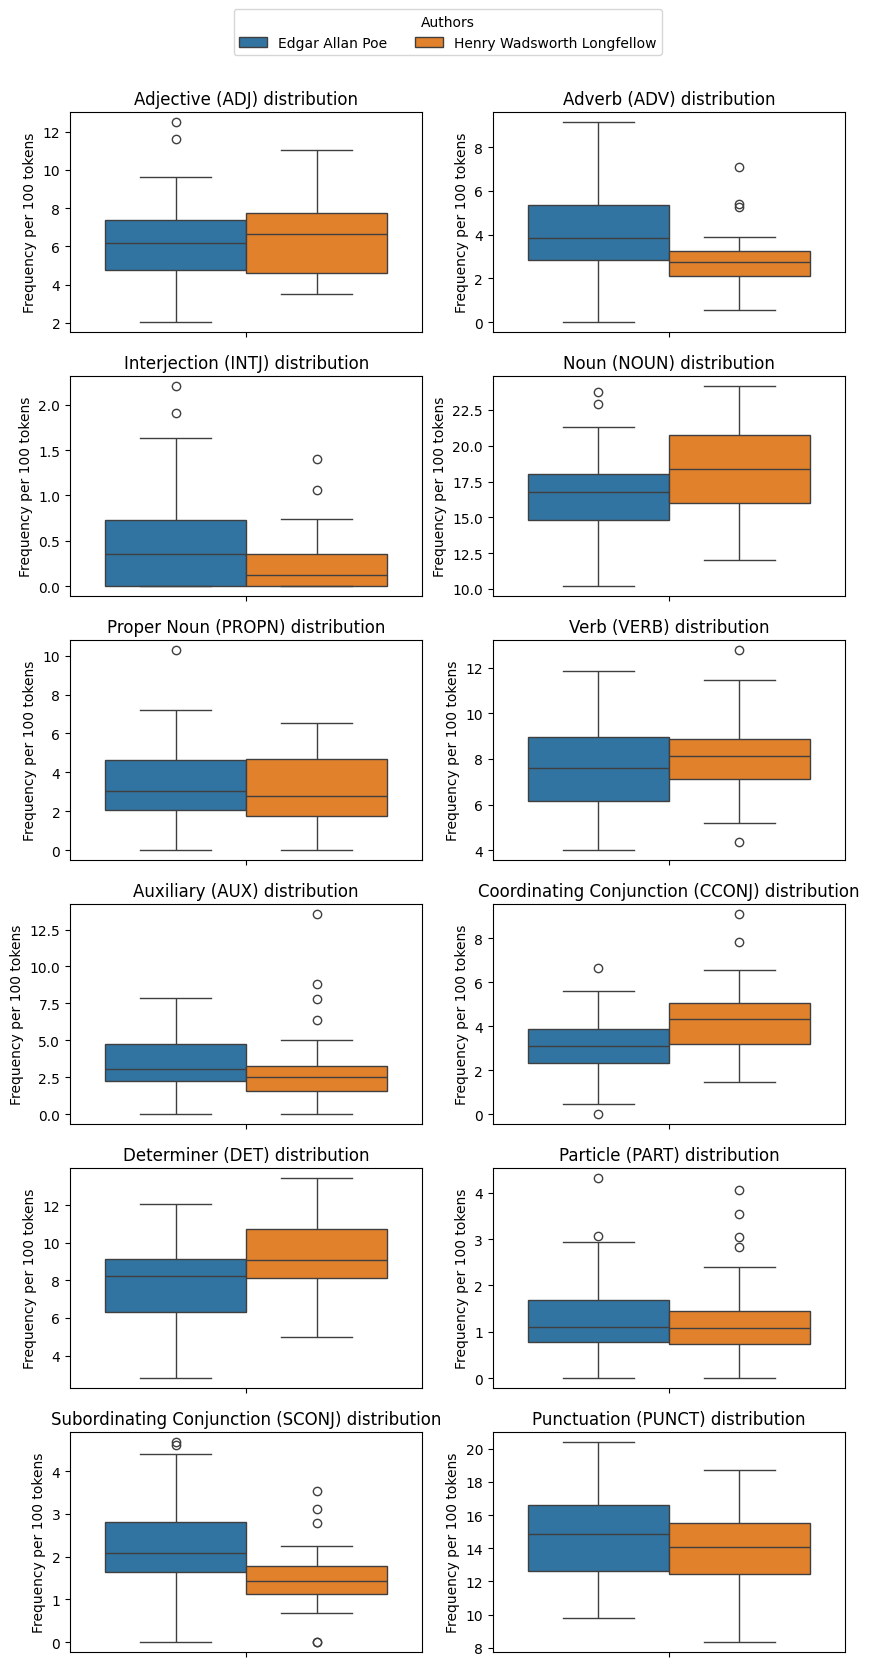

In [13]:
fig, axes = plt.subplots(6, 2, figsize=(10, 20))
ax = axes.flatten()

for num, pos_tag in enumerate(pos_tags):
    sns.boxplot(data=df, hue='author', y=pos_tag, legend=True if num == 0 else False, ax=ax[num])
    
    ax[num].set_title(f'{spacy.explain(pos_tag).title()} ({pos_tag}) distribution')
    ax[num].set_ylabel(f'Frequency per 100 tokens')

    if num == 0:
        sns.move_legend(
                ax[num], 
                "upper right", 
                bbox_to_anchor=(1.7, 1.5), 
                ncol=len(df['author'].unique()), 
                title='Authors', 
                frameon=True
            )

plt.show()